In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [71]:
train = [cv2.imread(f'./highway/input/in00{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1051, 1350)]
train_imgsGT = [cv2.imread(f'./highway/groundtruth/gt00{i}.png', cv2.IMREAD_GRAYSCALE)for i in range(1051, 1350)]

train_imgs = np.array(train)
train_imgs = train_imgs.astype(int)

train_imgsGT = np.array(train_imgsGT)
train_imgsGT = train_imgsGT.astype(int)


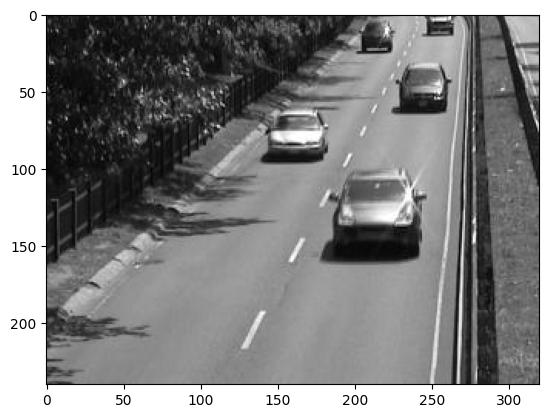

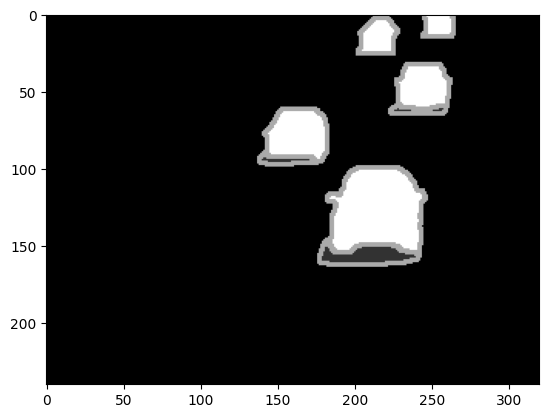

In [72]:
plt.imshow(train_imgs[0], cmap='gray')
plt.show()
plt.imshow(train_imgsGT[0], cmap='gray')
plt.show()

In [73]:
mean = np.mean(train_imgs, 0)
std = np.std(train_imgs, 0)

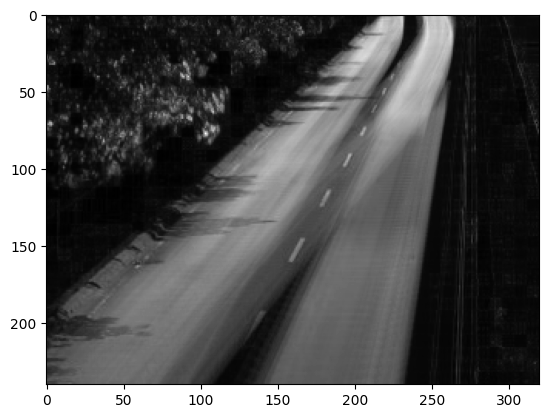

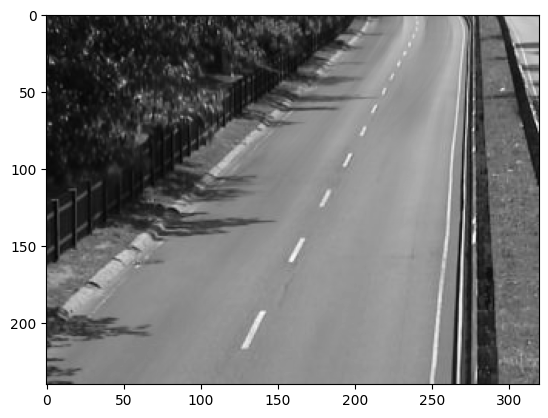

In [74]:
plt.imshow(std, cmap = "gray");
plt.show()
plt.imshow(mean, cmap = "gray");
plt.show()

In [75]:
results = [(train_imgs - mean) > threshold for threshold in np.arange(20, 110, 10)]


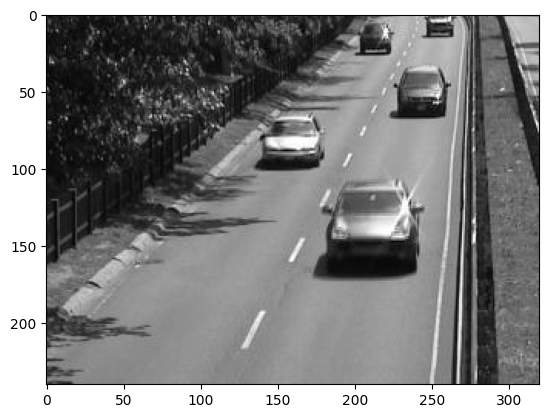

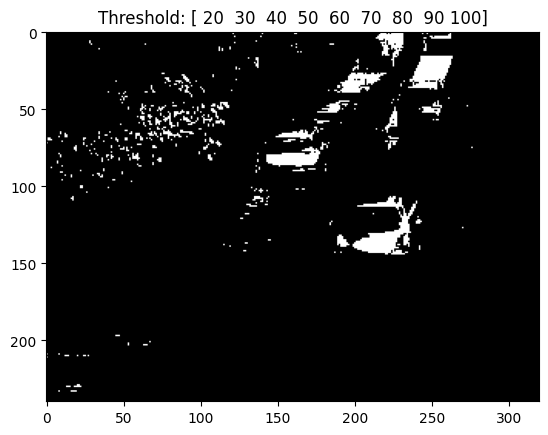

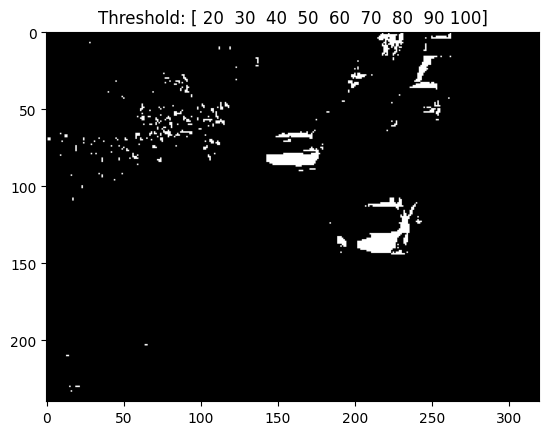

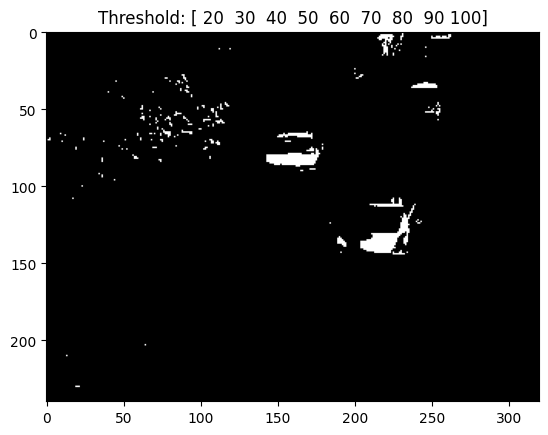

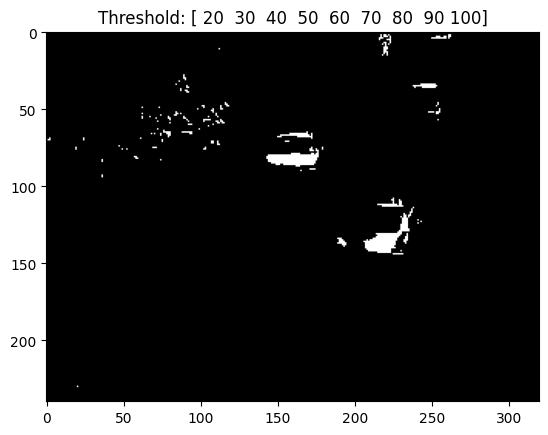

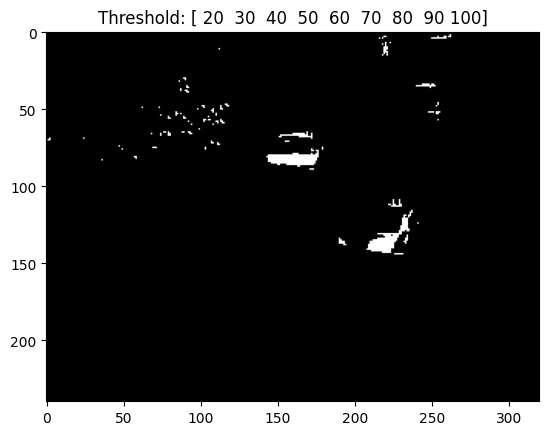

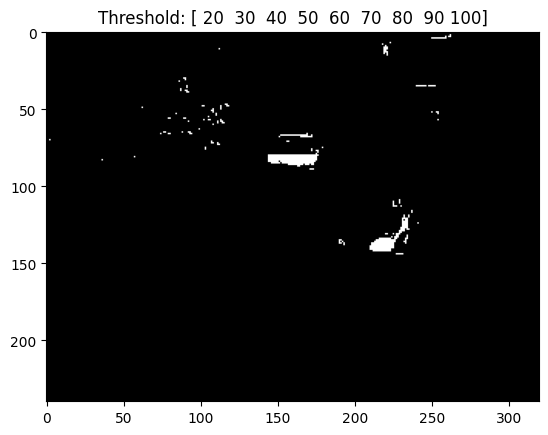

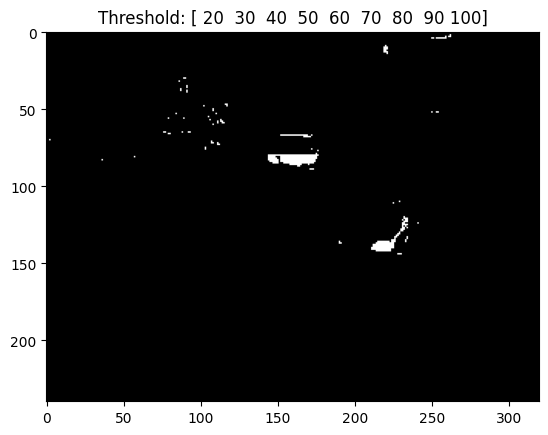

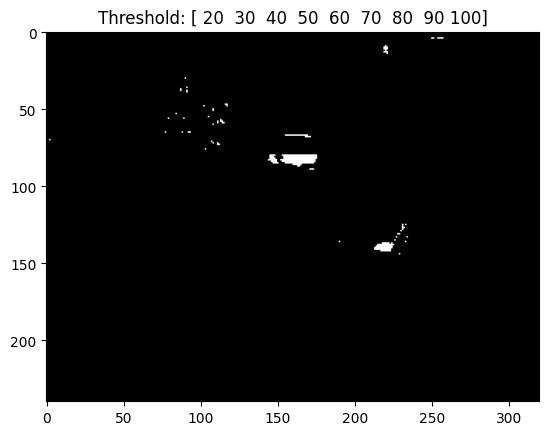

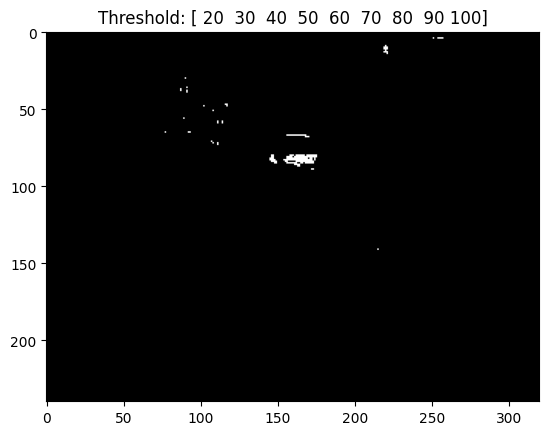

In [76]:
plt.imshow(train_imgs[3], cmap='gray')
plt.show()

for res in results:
    plt.title(f"Threshold: {np.arange(20, 110, 10)}")
    plt.imshow(res[3], cmap='gray')
    plt.show()

    




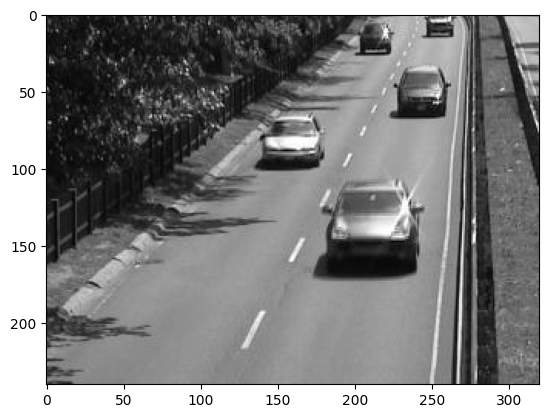

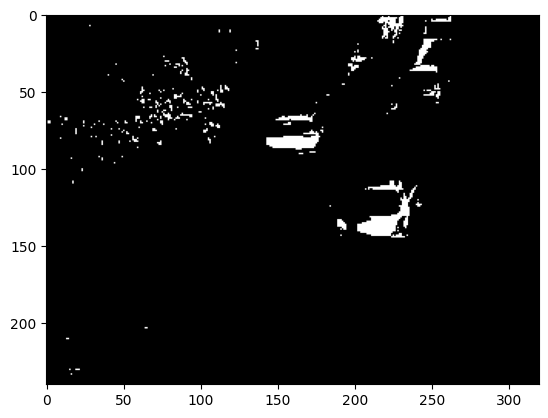

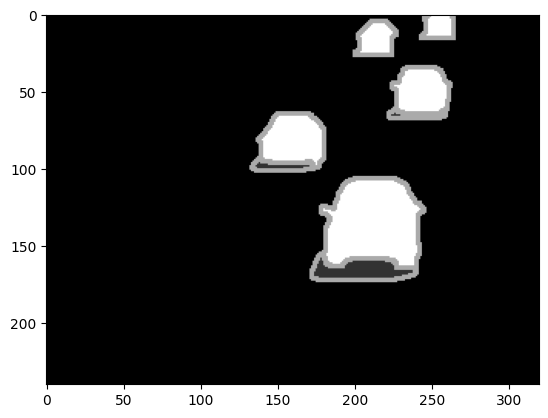

In [95]:
plt.imshow(train_imgs[3], cmap='gray')
plt.show()

plt.imshow(results[1][3], cmap='gray')
plt.show()


plt.imshow(train_imgsGT[3], cmap='gray')
plt.show()


In [120]:
unicos, frecuencias = np.unique(train_imgsGT, return_counts=True)
print(unicos, frecuencias)

results = [res.astype(int) * 255 for res in results]
unicos, frecuencias = np.unique(results[4], return_counts=True)
print(unicos, frecuencias)

[  0  50 170 255] [21186175    97990   513204  1165831]
[    0 65025] [22857469   105731]


In [121]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score




In [122]:
recall = [recall_score(train_imgsGT.flatten(), results[i].flatten(), pos_label=255, average='weighted') for i in range(0, len(results))]
precision = [precision_score(train_imgsGT.flatten(), results[i].flatten(), pos_label=255, average='weighted') for i in range(0, len(results))]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Vers

In [124]:
recall, precision, f1

([0.8766417136984392,
  0.9078243885869566,
  0.918104053442029,
  0.9211363398829432,
  0.921959308807135,
  0.9222308301978819,
  0.922367832009476,
  0.922454361761427,
  0.9225097547380156],
 [0.8568872801874744,
  0.8569142497423248,
  0.8561519157242681,
  0.8552961190520483,
  0.8545474242693712,
  0.8539164277343887,
  0.8533805256261755,
  0.8529155844206284,
  0.8524690148866616],
 [0.8741076143977069,
  0.8907404691853287,
  0.895101930527644,
  0.8951044892331641,
  0.8939062998241862,
  0.8925597782410767,
  0.8913053114351682,
  0.8901399676357766,
  0.8889597561040777])

In [133]:
results_dynamicThreshold = {}
for alpha in np.arange(1, 5, 1):
    results_dynamicThreshold[alpha] = []
    for beta in np.arange(20,110,10):
        results_dynamicThreshold[alpha].append(((train_imgs - mean) > alpha * std + beta).astype(int) * 255)

{1: [array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0

In [137]:
import tqdm

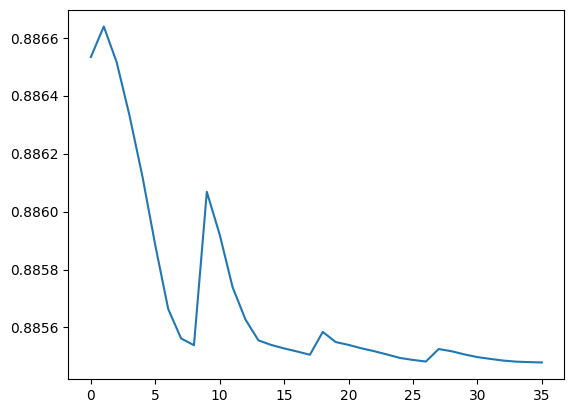

In [131]:
plt.plot(f1_dynamicThreshold)
plt.show()

In [141]:
f1_dynamicThreshold = {}
for i in results_dynamicThreshold.keys():
    print("alpha: ",i)
    f1_dynamicThreshold[i] = []
    for j in tqdm.tqdm(range(len(results_dynamicThreshold[i]))):
        print("beta: ",j)
        f1_dynamicThreshold[i].append(f1_score(train_imgsGT.flatten(), results_dynamicThreshold[i][j].flatten(), pos_label=255, average='weighted'))



alpha:  1


  0%|          | 0/9 [00:00<?, ?it/s]

beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 11%|█         | 1/9 [00:08<01:10,  8.76s/it]

beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 22%|██▏       | 2/9 [00:17<00:59,  8.49s/it]

beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 33%|███▎      | 3/9 [00:25<00:50,  8.38s/it]

beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 44%|████▍     | 4/9 [00:33<00:41,  8.33s/it]

beta:  4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 56%|█████▌    | 5/9 [00:41<00:33,  8.30s/it]

beta:  5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 67%|██████▋   | 6/9 [00:50<00:24,  8.27s/it]

beta:  6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 78%|███████▊  | 7/9 [00:58<00:16,  8.30s/it]

beta:  7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 89%|████████▉ | 8/9 [01:06<00:08,  8.29s/it]

beta:  8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
100%|██████████| 9/9 [01:14<00:00,  8.32s/it]


alpha:  2


  0%|          | 0/9 [00:00<?, ?it/s]

beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 11%|█         | 1/9 [00:08<01:05,  8.16s/it]

beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 22%|██▏       | 2/9 [00:16<00:58,  8.30s/it]

beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 33%|███▎      | 3/9 [00:24<00:49,  8.25s/it]

beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 44%|████▍     | 4/9 [00:33<00:41,  8.30s/it]

beta:  4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 56%|█████▌    | 5/9 [00:41<00:33,  8.29s/it]

beta:  5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 67%|██████▋   | 6/9 [00:49<00:25,  8.36s/it]

beta:  6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 78%|███████▊  | 7/9 [00:58<00:17,  8.54s/it]

beta:  7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 89%|████████▉ | 8/9 [01:08<00:08,  8.97s/it]

beta:  8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
100%|██████████| 9/9 [01:17<00:00,  8.59s/it]


alpha:  3


  0%|          | 0/9 [00:00<?, ?it/s]

beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 11%|█         | 1/9 [00:08<01:06,  8.26s/it]

beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 22%|██▏       | 2/9 [00:17<01:03,  9.05s/it]

beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 33%|███▎      | 3/9 [00:29<01:00, 10.08s/it]

beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 44%|████▍     | 4/9 [00:38<00:49,  9.85s/it]

beta:  4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 56%|█████▌    | 5/9 [00:47<00:37,  9.46s/it]

beta:  5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 67%|██████▋   | 6/9 [00:57<00:28,  9.60s/it]

beta:  6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 78%|███████▊  | 7/9 [01:06<00:18,  9.32s/it]

beta:  7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 89%|████████▉ | 8/9 [01:14<00:09,  9.04s/it]

beta:  8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
100%|██████████| 9/9 [01:22<00:00,  9.19s/it]


alpha:  4


  0%|          | 0/9 [00:00<?, ?it/s]

beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 11%|█         | 1/9 [00:08<01:07,  8.47s/it]

beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 22%|██▏       | 2/9 [00:16<00:58,  8.40s/it]

beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 33%|███▎      | 3/9 [00:25<00:50,  8.48s/it]

beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 44%|████▍     | 4/9 [00:34<00:43,  8.76s/it]

beta:  4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 56%|█████▌    | 5/9 [00:43<00:35,  8.89s/it]

beta:  5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 67%|██████▋   | 6/9 [00:52<00:26,  8.74s/it]

beta:  6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 78%|███████▊  | 7/9 [01:01<00:18,  9.09s/it]

beta:  7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
 89%|████████▉ | 8/9 [01:10<00:08,  8.95s/it]

beta:  8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
100%|██████████| 9/9 [01:19<00:00,  8.78s/it]


In [142]:
f1_dynamicThreshold

{1: [0.893902037217884,
  0.8928799081922452,
  0.8916381184116905,
  0.8903881503757938,
  0.889136948912393,
  0.8878061353266018,
  0.8865905630764119,
  0.8860053514643531,
  0.8858491165173505],
 2: [0.8894531046403218,
  0.8882666727385714,
  0.8871180368148865,
  0.886424019055669,
  0.8859841879727463,
  0.8858609273682653,
  0.8857722093856487,
  0.8857033352601733,
  0.8856356209483465],
 3: [0.8863423854317082,
  0.8860128477358554,
  0.8858877980800636,
  0.8857900249153637,
  0.8857156990548497,
  0.8856439440556663,
  0.8855735287408504,
  0.8855339864849406,
  0.8855023828082917],
 4: [0.8858268338608688,
  0.8857361841979815,
  0.8856548095406498,
  0.8855941121537534,
  0.8855550741781305,
  0.8855218849369217,
  0.8855000261639252,
  0.8854895358384679,
  0.8854819738353067]}

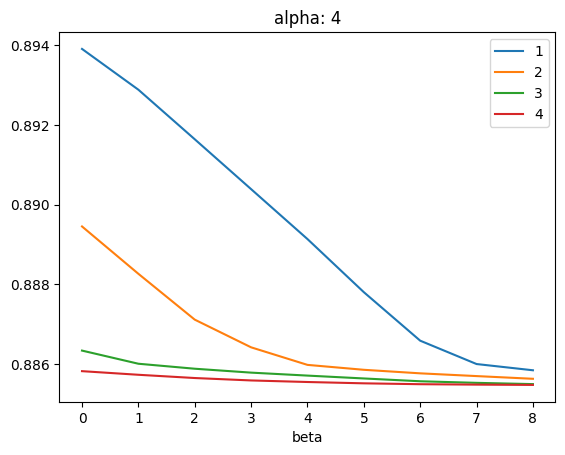

In [143]:
for i in f1_dynamicThreshold.keys():
    plt.title(f"alpha: {i}")
    plt.xlabel("beta")
    plt.plot(f1_dynamicThreshold[i], label=i)

plt.legend()
plt.show()

In [144]:
results_dynamicThreshold = {}
for alpha in np.arange(0, 1, 0.1):
    results_dynamicThreshold[alpha] = []
    for beta in np.arange(20,60,10):
        results_dynamicThreshold[alpha].append(((train_imgs - mean) > alpha * std + beta).astype(int) * 255)
f1_dynamicThreshold = {}
for i in results_dynamicThreshold.keys():
    print("alpha: ",i)
    f1_dynamicThreshold[i] = []
    for j in range(len(results_dynamicThreshold[i])):
        print("beta: ",j)
        f1_dynamicThreshold[i].append(f1_score(train_imgsGT.flatten(), results_dynamicThreshold[i][j].flatten(), pos_label=255, average='weighted'))



alpha:  0.0
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.1
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.2
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.30000000000000004
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.4
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.5
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.6000000000000001
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.7000000000000001
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.8
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


alpha:  0.9
beta:  0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


beta:  3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 255) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


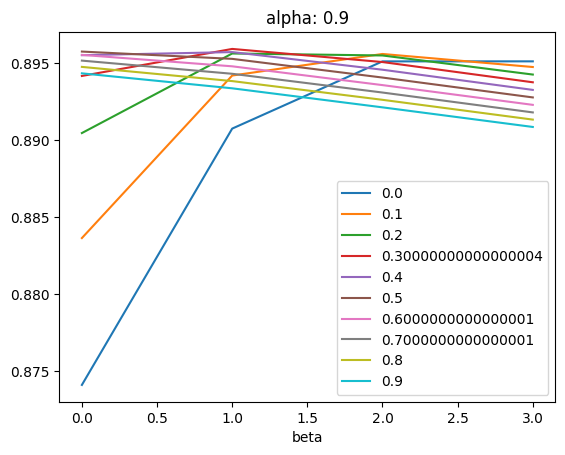

In [146]:
for i in f1_dynamicThreshold.keys():
    plt.title(f"alpha: {i}")
    plt.xlabel("beta")
    plt.plot(f1_dynamicThreshold[i], label=i)

plt.legend()
plt.show()